# Проект "Исследование видеоконтента Кинопоиск за 2014-2024 годы и прогнозирование рейтинга"

**Цели проекта:**
- Парсинг данных по API Кинопоиск.
- Исследование и очистка полученного датасета.
- Исследование видеоконтента, определение признаков и таргета.
- Построение модели машинного обучения для предсказания рейтинга.
- Отбор видеоконтента с высоким предсказанным рейтингом.

# 00. Подготовка ноутбука к работе

Импорты

In [973]:
# Standard library imports
import re
import json
import ast

# Third-party libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import spearmanr
import shap

# Scikit-learn preprocessing
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer

# Scikit-learn model selection and evaluation
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
)

# Scikit-learn machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

# Scikit-learn pipeline creation
from sklearn.pipeline import Pipeline

# Scikit-learn model evaluation metrics
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    r2_score
)

Функции, константы, пр.

In [974]:
# Функция для построения гистограммы

def plot_hist(data, column):
    """
    Plots a histogram for the specified column in the given DataFrame.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    column (str): The name of the column for which to plot the histogram.

    Returns:
    None: Displays a histogram plot of the specified column.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [975]:
# Функция для построения барплота

def plot_countplot(df, column):
    """
    Plots a count plot for the specified column in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The name of the column for which to plot the count plot.

    Returns:
    None: Displays a count plot of the specified column.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df[column], palette="Set2", edgecolor='black', hue=df[column], legend=False)
    plt.title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [976]:
# Константы
RANDOM_STATE = 42

# 0. Парсинг

# 1. Загрузка данных

In [977]:
# Парсинг был осуществлёно в два этапа, поэтому данные содержатся в двух файлах

# Часть 1
part_1 = pd.read_csv('/Users/kseniagabrusevich/Desktop/01/ML/Kinopoisk/data_14_19.csv')
part_1.head()

,Unnamed: 0,id,name,alternativeName,enName,type,typeNumber,year,description,shortDescription,...,backdrop,genres,countries,top10,top250,isSeries,ticketsOnSale,names,releaseYears,logo
0,0,1000048,Мама.com,A Dot Com Mom,NaN,movie,1,2016,Сулбхатай едет из Индии в США навестить своего...,Женщина из индийского городка летит в Америку ...,...,{'url': 'https://image.openmoviedb.com/kinopoi...,[{'name': 'драма'}],[{'name': 'Индия'}],NaN,NaN,False,False,NaN,NaN,NaN
1,1,5166411,NaN,Travis Scott: Butterfly Effect,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'США'}],NaN,NaN,False,False,NaN,NaN,NaN
2,2,4930664,NaN,Arch Enemy: The Race,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN
3,3,4931329,NaN,Arch Enemy: War Eternal,NaN,movie,1,2014,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN
4,4,4931313,NaN,Arch Enemy: The World Is Yours,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN


In [978]:
# Часть 2
part_2 = pd.read_csv('/Users/kseniagabrusevich/Desktop/01/ML/Kinopoisk/data_20_24.csv')
part_2.head()

,Unnamed: 0,id,name,alternativeName,enName,type,typeNumber,year,description,shortDescription,...,genres,countries,top10,top250,isSeries,ticketsOnSale,backdrop,names,logo,releaseYears
0,0,5900248,Skywalkers: История одной пары,Skywalkers: A Love Story,NaN,movie,1,2024,Две сорвиголовы проверяют свои любовь и довери...,NaN,...,[{'name': 'документальный'}],[{'name': 'США'}],NaN,NaN,False,False,NaN,NaN,NaN,NaN
1,1,5926389,Доктор Кто: Пункт назначения – Скаро,Doctor Who: Destination - Skaro,NaN,movie,1,2023,На планете Скаро Даврос представляет своему по...,NaN,...,"[{'name': 'короткометражка'}, {'name': 'фантас...",[{'name': 'Великобритания'}],NaN,NaN,False,False,NaN,NaN,NaN,NaN
2,2,5617802,Выпусти меня,NaN,NaN,movie,1,2024,"Отец и сын отправляются в поход, чтобы наслади...",NaN,...,[{'name': 'триллер'}],[{'name': 'Россия'}],NaN,NaN,False,False,NaN,NaN,NaN,NaN
3,3,5939650,Виселица. Жертва призрака,Dark House,NaN,movie,1,2023,Студентка Низа решает провести ночь в заброшен...,NaN,...,[{'name': 'ужасы'}],[{'name': 'Камбоджа'}],NaN,NaN,False,False,NaN,NaN,NaN,NaN
4,4,6000386,Ячейка общества,NaN,NaN,movie,1,2024,В жизни молодой семьи важное событие — ребёнок...,NaN,...,[{'name': 'драма'}],[{'name': 'Россия'}],NaN,NaN,False,True,NaN,NaN,NaN,NaN


In [979]:
# Объединение
df = pd.concat([part_1, part_2], axis=0, ignore_index=True)
df.head()

,Unnamed: 0,id,name,alternativeName,enName,type,typeNumber,year,description,shortDescription,...,backdrop,genres,countries,top10,top250,isSeries,ticketsOnSale,names,releaseYears,logo
0,0,1000048,Мама.com,A Dot Com Mom,NaN,movie,1,2016,Сулбхатай едет из Индии в США навестить своего...,Женщина из индийского городка летит в Америку ...,...,{'url': 'https://image.openmoviedb.com/kinopoi...,[{'name': 'драма'}],[{'name': 'Индия'}],NaN,NaN,False,False,NaN,NaN,NaN
1,1,5166411,NaN,Travis Scott: Butterfly Effect,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'США'}],NaN,NaN,False,False,NaN,NaN,NaN
2,2,4930664,NaN,Arch Enemy: The Race,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN
3,3,4931329,NaN,Arch Enemy: War Eternal,NaN,movie,1,2014,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN
4,4,4931313,NaN,Arch Enemy: The World Is Yours,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN


In [980]:
# Проверка корректности объединения
assert df.shape[0] == part_1.shape[0] + part_2.shape[0], 'error while concat'
assert df.shape[1] == part_1.shape[1] & df.shape[1] == part_2.shape[1], 'error while concat'

# 2. Первичная обработка

In [981]:
# Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74500 entries, 0 to 74499
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         74500 non-null  int64  
 1   id                 74500 non-null  int64  
 2   name               12283 non-null  object 
 3   alternativeName    70454 non-null  object 
 4   enName             0 non-null      float64
 5   type               74500 non-null  object 
 6   typeNumber         74500 non-null  int64  
 7   year               74500 non-null  int64  
 8   description        8695 non-null   object 
 9   shortDescription   4583 non-null   object 
 10  status             152 non-null    object 
 11  rating             74500 non-null  object 
 12  votes              74500 non-null  object 
 13  movieLength        51969 non-null  float64
 14  totalSeriesLength  0 non-null      float64
 15  seriesLength       0 non-null      float64
 16  ratingMpaa         155

In [982]:
df.head(3)

,Unnamed: 0,id,name,alternativeName,enName,type,typeNumber,year,description,shortDescription,...,backdrop,genres,countries,top10,top250,isSeries,ticketsOnSale,names,releaseYears,logo
0,0,1000048,Мама.com,A Dot Com Mom,NaN,movie,1,2016,Сулбхатай едет из Индии в США навестить своего...,Женщина из индийского городка летит в Америку ...,...,{'url': 'https://image.openmoviedb.com/kinopoi...,[{'name': 'драма'}],[{'name': 'Индия'}],NaN,NaN,False,False,NaN,NaN,NaN
1,1,5166411,NaN,Travis Scott: Butterfly Effect,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'США'}],NaN,NaN,False,False,NaN,NaN,NaN
2,2,4930664,NaN,Arch Enemy: The Race,NaN,movie,1,2017,NaN,NaN,...,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],NaN,NaN,False,False,NaN,NaN,NaN


In [983]:
df.columns

Index(['Unnamed: 0', 'id', 'name', 'alternativeName', 'enName', 'type',
       'typeNumber', 'year', 'description', 'shortDescription', 'status',
       'rating', 'votes', 'movieLength', 'totalSeriesLength', 'seriesLength',
       'ratingMpaa', 'ageRating', 'poster', 'backdrop', 'genres', 'countries',
       'top10', 'top250', 'isSeries', 'ticketsOnSale', 'names', 'releaseYears',
       'logo'],
      dtype='object')

In [984]:
# Cтолбец не понадобится при дальнейшем анализе
df['enName'].value_counts()

Series([], Name: count, dtype: int64)

In [985]:
# Cтолбец не понадобится при дальнейшем анализе
df['type'].value_counts()

type
movie    74500
Name: count, dtype: int64

In [986]:
# Cтолбец не понадобится при дальнейшем анализе
df['typeNumber'].value_counts()

typeNumber
1    74500
Name: count, dtype: int64

In [987]:
df['status'].value_counts()

status
post-production    80
completed          41
filming            18
pre-production     13
Name: count, dtype: int64

In [988]:
# Cтолбец не понадобится при дальнейшем анализе
df['status'].isna().mean()

0.9979597315436242

In [989]:
# Столбцы, которые необходимо оставить
cols_to_keep = [ 
    'id', 
    'name', 
    'alternativeName', 
    'year',
    'rating',
    'movieLength',
    'ageRating', 
    'genres',
    'countries',
    'ticketsOnSale',
    ]

In [990]:
# Удаление лишних столбцов
df = df[cols_to_keep]
df.head()

,id,name,alternativeName,year,rating,movieLength,ageRating,genres,countries,ticketsOnSale
0,1000048,Мама.com,A Dot Com Mom,2016,"{'kp': 0, 'imdb': 5.4, 'filmCritics': 0, 'russ...",123.0,18.0,[{'name': 'драма'}],[{'name': 'Индия'}],False
1,5166411,NaN,Travis Scott: Butterfly Effect,2017,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",4.0,NaN,[{'name': 'музыка'}],[{'name': 'США'}],False
2,4930664,NaN,Arch Enemy: The Race,2017,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",3.0,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],False
3,4931329,NaN,Arch Enemy: War Eternal,2014,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",4.0,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],False
4,4931313,NaN,Arch Enemy: The World Is Yours,2017,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",5.0,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],False


In [991]:
# Корректировка регистра
def to_snake_case(text):
    new_text = re.sub(pattern= r'(?<!^)(?<!_)([A-Z])',
                      repl=r'_\1',
                      string=text)
    return new_text.lower()

In [992]:
# Корректировка регистра
df.columns = [to_snake_case(col) for col in df.columns]
df.columns

Index(['id', 'name', 'alternative_name', 'year', 'rating', 'movie_length',
       'age_rating', 'genres', 'countries', 'tickets_on_sale'],
      dtype='object')

In [993]:
# Проверка на полные дубликаты
df.duplicated().sum()

0

In [994]:
# Заполнение пропусков в колонке "имя"
df['name'] = df['name'].fillna(df['alternative_name'])

In [995]:
def extract_names(row):
    try:
        # Convert the string representation of the list to an actual list
        data_list = ast.literal_eval(row)
        # Extract the first name if the list is not empty and contains only one dictionary
        if isinstance(data_list, list) and len(data_list) > 0 and isinstance(data_list[0], dict):
            return data_list[0].get('name', None)
        else:
            return None
    except (ValueError, SyntaxError):
        # Handle cases where ast.literal_eval fails
        return None

In [996]:
# Apply the function to the column
df['country'] = df['countries'].apply(extract_names)
df['genre'] = df['genres'].apply(extract_names)

In [997]:
df.head()

,id,name,alternative_name,year,rating,movie_length,age_rating,genres,countries,tickets_on_sale,country,genre
0,1000048,Мама.com,A Dot Com Mom,2016,"{'kp': 0, 'imdb': 5.4, 'filmCritics': 0, 'russ...",123.0,18.0,[{'name': 'драма'}],[{'name': 'Индия'}],False,Индия,драма
1,5166411,Travis Scott: Butterfly Effect,Travis Scott: Butterfly Effect,2017,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",4.0,NaN,[{'name': 'музыка'}],[{'name': 'США'}],False,США,музыка
2,4930664,Arch Enemy: The Race,Arch Enemy: The Race,2017,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",3.0,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],False,Швеция,музыка
3,4931329,Arch Enemy: War Eternal,Arch Enemy: War Eternal,2014,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",4.0,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],False,Швеция,музыка
4,4931313,Arch Enemy: The World Is Yours,Arch Enemy: The World Is Yours,2017,"{'kp': 0, 'imdb': 0, 'filmCritics': 0, 'russia...",5.0,NaN,[{'name': 'музыка'}],[{'name': 'Швеция'}],False,Швеция,музыка


In [998]:
# Функция для преобразования строки в правильный формат JSON
def fix_json_string(json_str):
    # Заменяем одинарные кавычки на двойные и None на null
    json_str = json_str.replace("'", '"').replace('None', 'null')
    return json_str

# Применение функции к столбцу и преобразование строк JSON в словари
df['rating'] = df['rating'].apply(lambda x: json.loads(fix_json_string(x)))

# Извлечение значений рейтингов в новые столбцы
df['rating_kp'] = df['rating'].apply(lambda x: x.get('kp'))
df['rating_imdb'] = df['rating'].apply(lambda x: x.get('imdb'))

In [999]:
# Удаление ненужных столбцов
df.drop(['alternative_name', 'countries', 'genres', 'rating'], axis=1, inplace=True)

In [1000]:
# Итоговый датасет
df.head()

,id,name,year,movie_length,age_rating,tickets_on_sale,country,genre,rating_kp,rating_imdb
0,1000048,Мама.com,2016,123.0,18.0,False,Индия,драма,0.0,5.4
1,5166411,Travis Scott: Butterfly Effect,2017,4.0,NaN,False,США,музыка,0.0,0.0
2,4930664,Arch Enemy: The Race,2017,3.0,NaN,False,Швеция,музыка,0.0,0.0
3,4931329,Arch Enemy: War Eternal,2014,4.0,NaN,False,Швеция,музыка,0.0,0.0
4,4931313,Arch Enemy: The World Is Yours,2017,5.0,NaN,False,Швеция,музыка,0.0,0.0


# 3. EDA

In [1001]:
# Общая информация по датафрейму
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74500 entries, 0 to 74499
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74500 non-null  int64  
 1   name             74500 non-null  object 
 2   year             74500 non-null  int64  
 3   movie_length     51969 non-null  float64
 4   age_rating       7502 non-null   float64
 5   tickets_on_sale  74500 non-null  bool   
 6   country          70942 non-null  object 
 7   genre            73578 non-null  object 
 8   rating_kp        74500 non-null  float64
 9   rating_imdb      74500 non-null  float64
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 5.2+ MB


In [1002]:
# Пропуски
df.isna().mean().sort_values(ascending=False)

age_rating         0.899302
movie_length       0.302430
country            0.047758
genre              0.012376
id                 0.000000
name               0.000000
year               0.000000
tickets_on_sale    0.000000
rating_kp          0.000000
rating_imdb        0.000000
dtype: float64

In [1003]:
# Уникальные значения
for col in df.columns:
    print(col, len(df[col].unique()))

id 74500
name 72606
year 11
movie_length 343
age_rating 6
tickets_on_sale 2
country 166
genre 31
rating_kp 2903
rating_imdb 92


- Отмечается, что есть повторяющиеся названия фильмов, вероятно, фильмы с одинаковым названием выходили в разных странах.
- Число лет соответствует необходимому для исследования интервалу (2014-2024).
- Отмечаются, как непрерывные, так и дискретные признаки.
- Далее приводится анализ каждого признака по отдельности.

## 3.1 Год

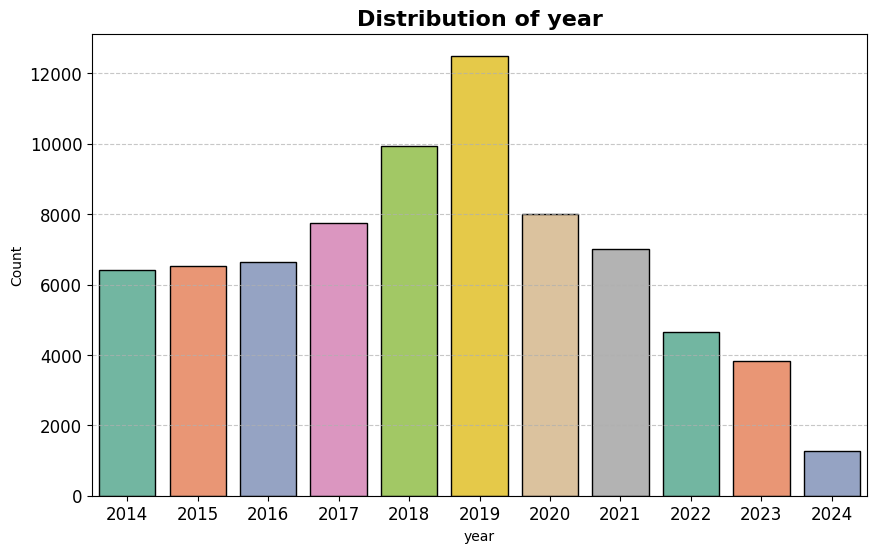

In [1004]:
# Визуализация распределения числа фильмов по годам
plot_countplot(df, 'year')

In [1005]:
# Число фильмов по годам
df['year'].value_counts(ascending=False)

year
2019    12502
2018     9929
2020     8009
2017     7750
2021     7013
2016     6632
2015     6525
2014     6412
2022     4651
2023     3819
2024     1258
Name: count, dtype: int64

- Отмечается, что больше всего видеоконтента представлено за 2019 год.

## 3.2 Длительность фильмов

In [1006]:
# Статистика по признаку
df['movie_length'].describe()

count    51969.000000
mean        37.033789
std         54.659986
min          1.000000
25%          4.000000
50%          7.000000
75%         78.000000
max       3720.000000
Name: movie_length, dtype: float64

- Отмечается высокая дисперсия и сильное отличие среднего от медианы.

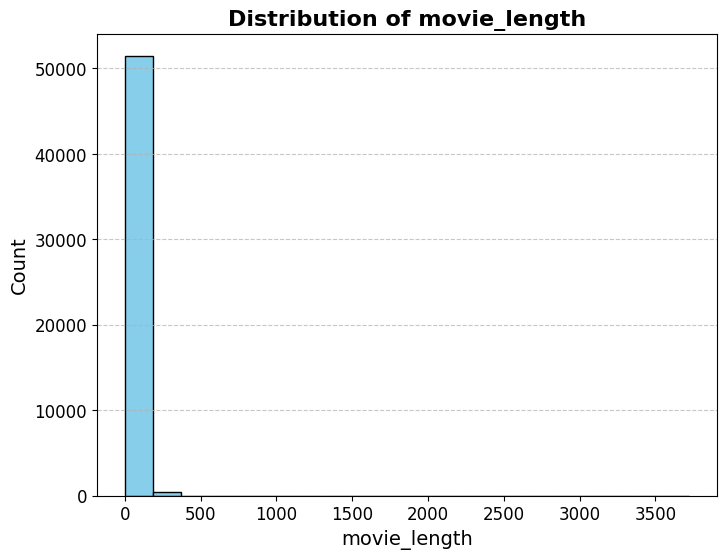

In [1007]:
# Распределение признака
plot_hist(df, 'movie_length')

In [1008]:
q1 = df['movie_length'].quantile(0.1)
q2 = df['movie_length'].quantile(0.9)

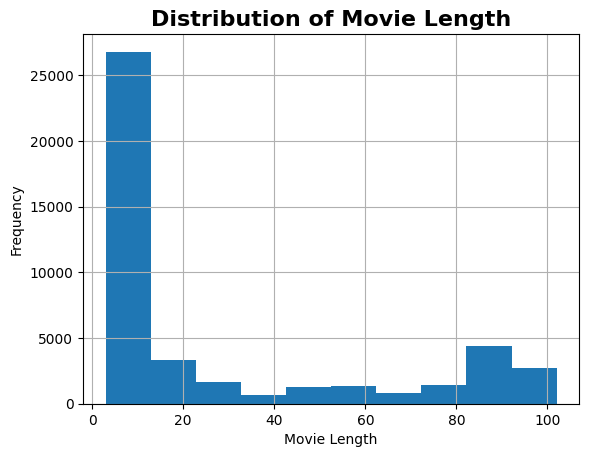

In [1009]:
df[df['movie_length'].between(q1,q2)]['movie_length'].hist()

plt.title(f'Distribution of Movie Length', fontsize=16, fontweight='bold')
plt.xlabel('Movie Length')
plt.ylabel('Frequency')
plt.show()

- Распределение не симметричное, бимодальное.
- Очевидно, что в датасете содержится разнообразный видеоконтент. Первый пик вероятно относится к короткометражным фильмам, видео-клипам, второй в фильмам и сериалам.

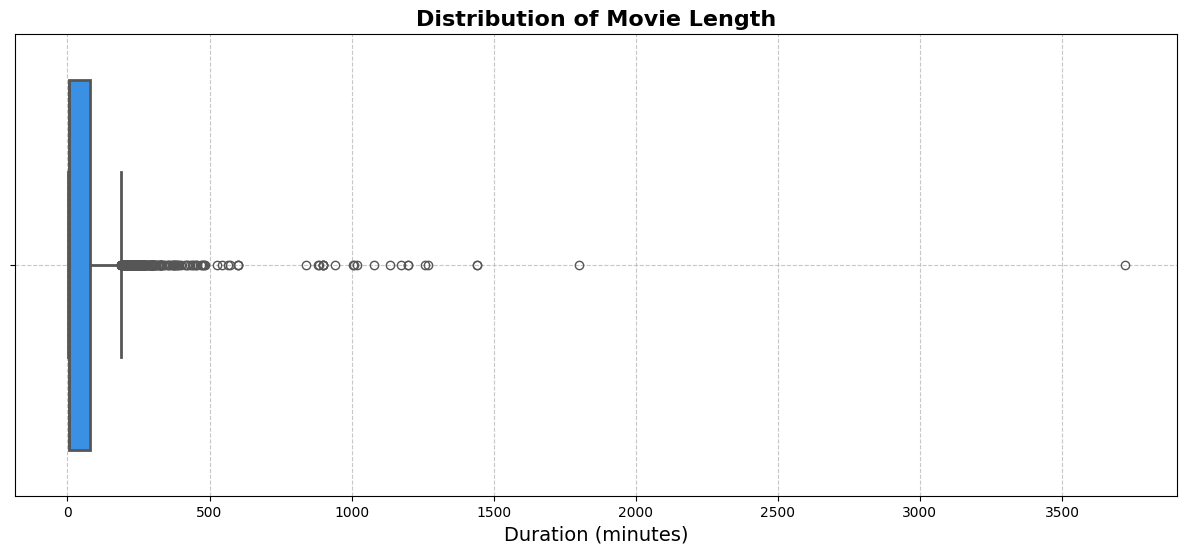

In [1010]:
# Боксплот
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['movie_length'], orient='h', color='dodgerblue', linewidth=2)
plt.title('Distribution of Movie Length', fontsize=16, fontweight='bold')
plt.xlabel('Duration (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

- На боксплоте если признаки, выходящие за пределы "усов". Однако, нельзя утверждать, что это ошибки в данных.

**Исследование первого пика (коротких фильмов, до 15 минут)**

In [1011]:
# Фильмы длительностью до 15 минут
short_films = df[df['movie_length'] <= 15]

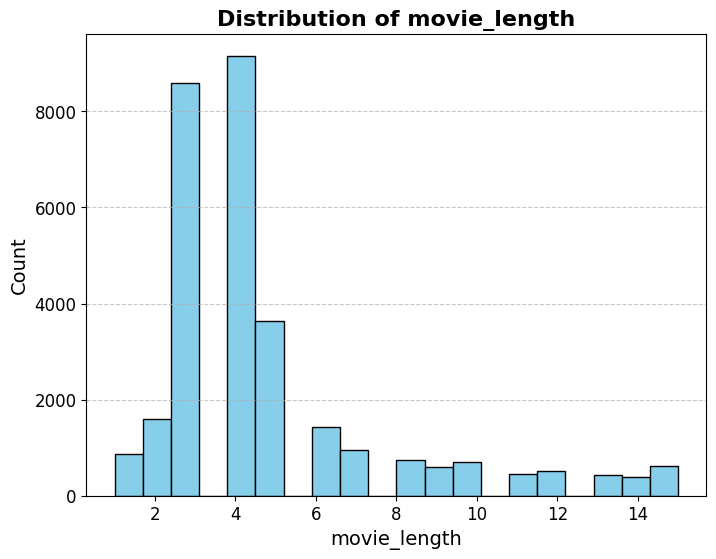

In [1012]:
# Распределение длительности для контента менее 15 минут
plot_hist(short_films, 'movie_length')

In [1013]:
# Жанры
short_films['genre'].value_counts(normalize=True)

genre
короткометражка    0.695877
музыка             0.254787
документальный     0.027511
комедия            0.003594
драма              0.003561
мюзикл             0.003169
фэнтези            0.002385
ужасы              0.001862
фантастика         0.001830
мелодрама          0.001732
боевик             0.001078
триллер            0.000817
новости            0.000490
криминал           0.000229
спорт              0.000196
детектив           0.000163
приключения        0.000163
реальное ТВ        0.000131
вестерн            0.000131
биография          0.000098
военный            0.000065
история            0.000065
семейный           0.000033
для взрослых       0.000033
Name: proportion, dtype: float64

- Большую часть видеоконтента представляют собой короткометражные фильмы и музыка.

Исследование данных, выходящих за пределы "усов" боксплота.

In [1014]:
# Фильмы более 800 мин.
df[df['movie_length'] >= 800].sort_values(by='movie_length', ascending=False)

,id,name,year,movie_length,age_rating,tickets_on_sale,country,genre,rating_kp,rating_imdb
38606,5138358,Waiting with Huell,2019,3720.0,NaN,False,США,драма,0.0,0.0
30282,1188759,Juney Smith's Black American Film Collection,2016,1800.0,NaN,False,США,криминал,0.0,0.0
46268,863115,24h Jerusalem,2014,1440.0,NaN,False,Германия,документальный,0.0,9.0
37074,5155380,Sigur rós: Route One,2016,1440.0,NaN,False,Исландия,мюзикл,0.0,0.0
28866,4632994,Lsnienie (Audioplay),2016,1268.0,NaN,False,Польша,ужасы,0.0,0.0
30017,868056,Ghost Shrink,2014,1260.0,NaN,False,США,фэнтези,0.0,0.0
14791,1254521,Black Cock Lovers Vol. 2,2018,1200.0,18.0,False,США,для взрослых,0.0,0.0
14824,1254283,Sexy Wet Asses Vol. 3,2019,1200.0,18.0,False,США,для взрослых,0.0,0.0
30245,1416077,The Longest 5 Seconds on YouTube,2016,1174.0,NaN,False,Великобритания,документальный,0.0,0.0
30046,4652745,Ojciec chrzestny (Audioplay),2014,1134.0,NaN,False,Польша,драма,0.0,0.0


- Самый длинный "фильм" в действительности имеет такую длительность (https://www.imdb.com/title/tt21833438/) и является телепередачей.
- Прочий видеоконтент также вполне адекватен и не является ошибкой в данных.

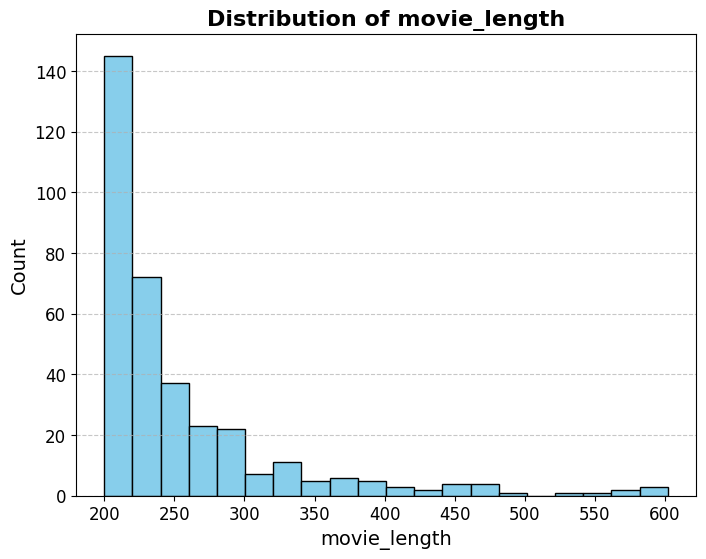

In [1015]:
# Длинные фильмы
long_films = df[(df['movie_length'] >= 200) & (df['movie_length'] < 800)]

plot_hist(long_films, 'movie_length')

In [1016]:
# Жанры
long_films['genre'].value_counts(normalize=True)

genre
для взрослых      0.368421
музыка            0.192982
спорт             0.093567
драма             0.078947
боевик            0.049708
документальный    0.046784
ужасы             0.026316
мюзикл            0.023392
комедия           0.023392
фантастика        0.020468
мелодрама         0.011696
фэнтези           0.011696
новости           0.008772
церемония         0.008772
криминал          0.005848
приключения       0.005848
триллер           0.005848
игра              0.002924
реальное ТВ       0.002924
военный           0.002924
история           0.002924
концерт           0.002924
биография         0.002924
Name: proportion, dtype: float64

- Здесь преобладает контент помеченный как "для взрослых".

## 3.3 Возрастные ограничения

In [1017]:
# Пропуски
df['age_rating'].isna().mean()

0.8993020134228188

В данном признаке пропущено более 90% процентов данных.

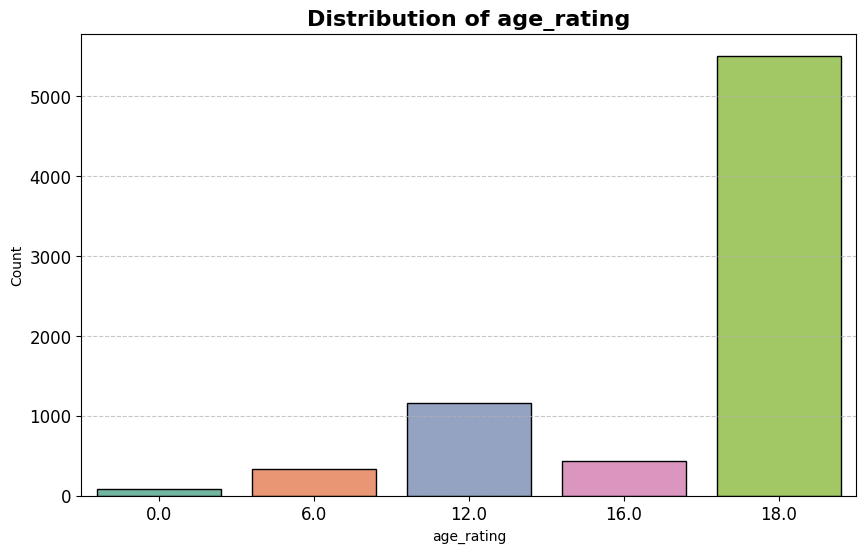

In [1018]:
# Распределение признака
plot_countplot(df, 'age_rating')

- Из представленных в датасете данных преобладает контент для пользователей 18+.

Интересно посмотреть, какой жанр преобладает в той или иной возрастной категории.

In [1019]:
age_rating = df.dropna(subset=['age_rating'])
age_rating['age_rating'].unique()

array([18., 12.,  6., 16.,  0.])

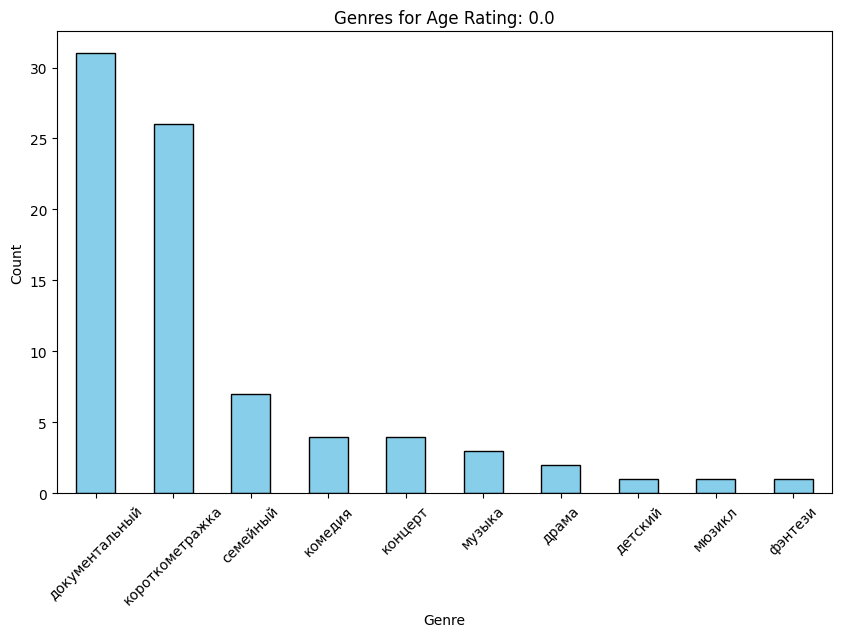

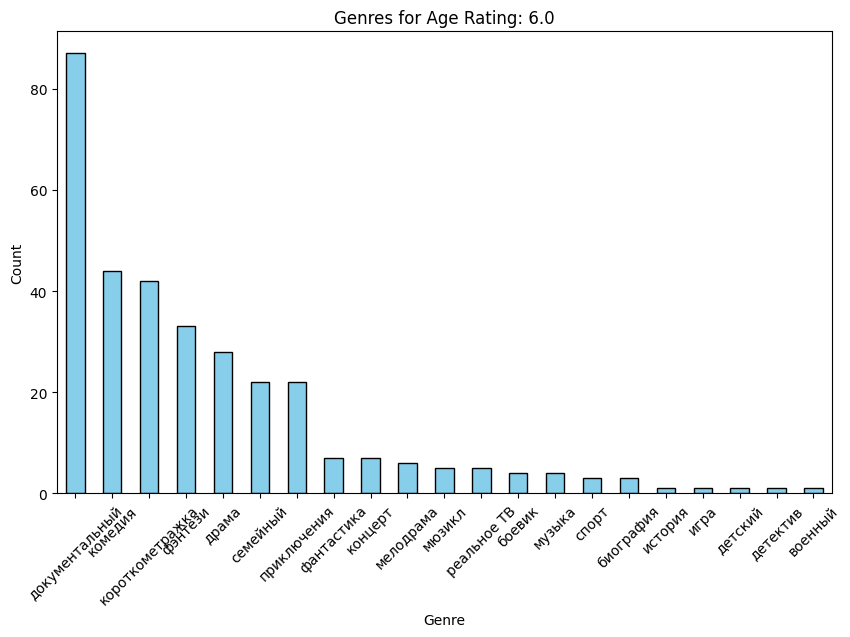

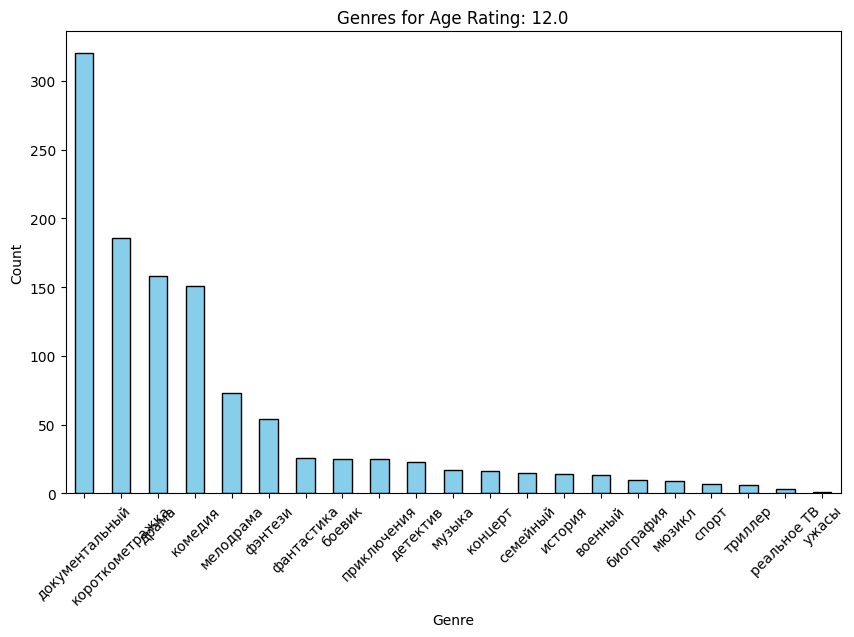

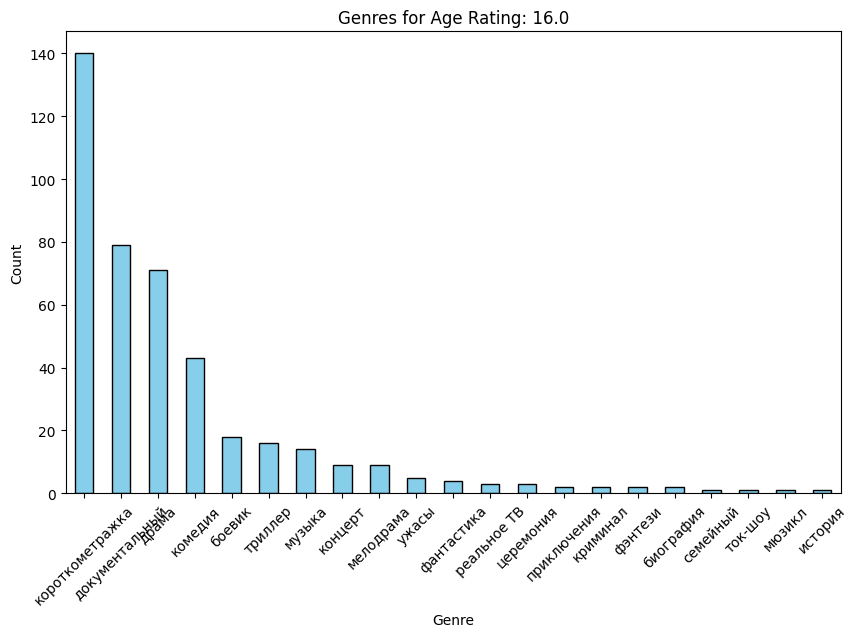

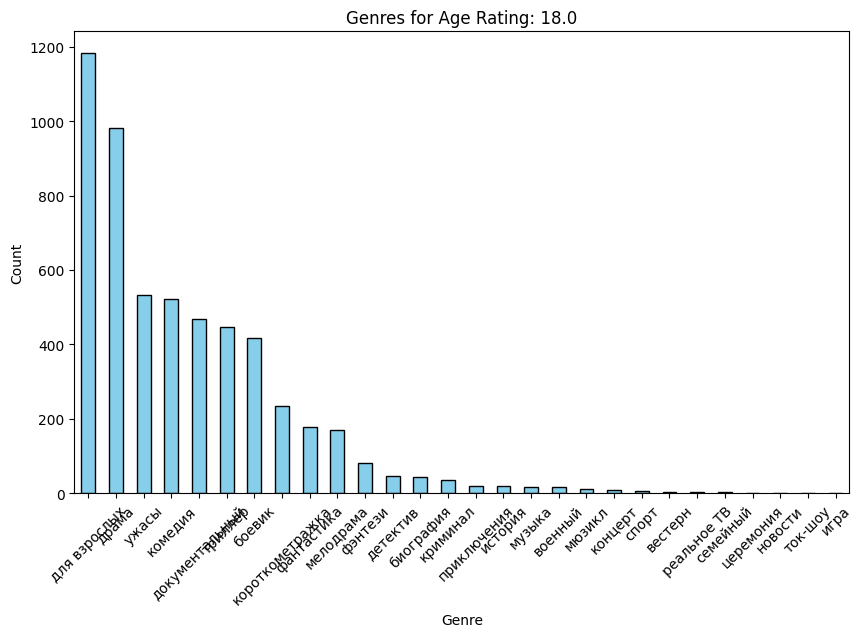

In [1020]:
ages = age_rating['age_rating'].unique()

for age in sorted(ages):
    
    filtered_df = age_rating[age_rating['age_rating'] == age]
    
    genre_counts = filtered_df.groupby('genre')['name'].count().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Genres for Age Rating: {age}')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

## 3.4 Страна

In [1021]:
# Число уникальных значений (количество стран в датасете)
len(df['country'].unique())

166

In [1022]:
# Топ 10 стран по количеству выпущенного контента
df.groupby('country')[['name']].count().sort_values(by='name', ascending=False)[:10]


,name
country,
США,30373
Великобритания,4764
Индия,4279
Россия,3870
Канада,3764
Франция,3184
Германия,2565
Испания,1425
Италия,1253


- По количеству выпускаемого видео-контента лидирует США, Россия стоит на 4-м месте.
- Интересно сравнить по жанрам.

In [1023]:
_q1 = df['country'] == 'США'
_q2 = df['country'] == 'Россия'

In [1024]:
usa = (
    df[_q1]
    .groupby('genre')[['id']]
    .count()
    .sort_values(by='id', ascending=False)
    .rename(columns={'id': 'count_usa'})
)
usa.head()

,count_usa
genre,
короткометражка,16872
музыка,4234
документальный,2064
комедия,1293
драма,1133


In [1025]:
usa['ratio_usa'] = round(usa['count_usa'] / len(df[_q1]) * 100)

In [1026]:
usa.head()

,count_usa,ratio_usa
genre,,
короткометражка,16872,56.0
музыка,4234,14.0
документальный,2064,7.0
комедия,1293,4.0
драма,1133,4.0


In [1027]:
russia = (
    df[_q2]
    .groupby('genre')[['id']]
    .count().sort_values(by='id', ascending=False)
    .rename(columns={'id': 'count_russia'})
)
russia.head()

,count_russia
genre,
короткометражка,1672
документальный,913
драма,415
комедия,316
мелодрама,110


In [1028]:
russia['ratio_russia'] = round(russia['count_russia'] / len(df[_q2]) * 100)

In [1029]:
russia.head()

,count_russia,ratio_russia
genre,,
короткометражка,1672,43.0
документальный,913,24.0
драма,415,11.0
комедия,316,8.0
мелодрама,110,3.0


In [1030]:
_df = russia.merge(usa, on='genre')

In [1031]:
_df

,count_russia,ratio_russia,count_usa,ratio_usa
genre,,,,
короткометражка,1672,43.0,16872,56.0
документальный,913,24.0,2064,7.0
драма,415,11.0,1133,4.0
комедия,316,8.0,1293,4.0
мелодрама,110,3.0,331,1.0
детектив,66,2.0,44,0.0
триллер,45,1.0,487,2.0
приключения,31,1.0,53,0.0
боевик,30,1.0,632,2.0


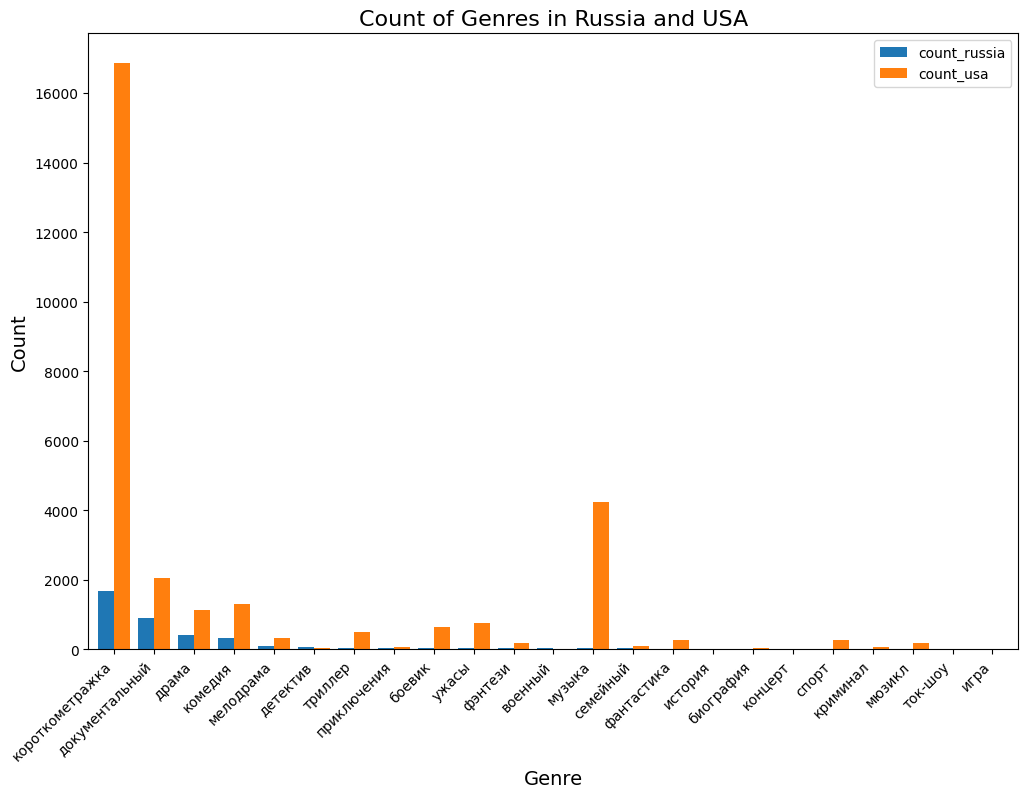

In [1032]:
_df[['count_russia', 'count_usa']].plot(kind='bar', figsize=(12, 8), width=0.8)

plt.title('Count of Genres in Russia and USA', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.show()

Видно, что большую долю видеоконтента, выпускаемого США и Россией, составляют короткометражные фильмы. Интересно посмотреть, сильно ли изменится ли картина, если исключить этот жанр из анализа.

In [1033]:
_q3 = df['genre'] != 'короткометражка'

In [1034]:
df[_q3].groupby('country')[['id']].count().sort_values(by='id', ascending=False)[:10]

,id
country,
США,13501
Великобритания,2198
Россия,2198
Индия,2032
Франция,1882
Германия,1709
Канада,1525
Япония,998
Испания,655


США по прежнему лидирует.

## 3.5 Жанр

In [1035]:
# Виды жанров в датасете
df['genre'].unique()

array(['драма', 'музыка', 'короткометражка', 'фантастика',
       'документальный', 'мелодрама', 'для взрослых', 'триллер', 'ужасы',
       'фэнтези', 'боевик', 'комедия', 'криминал', 'семейный', 'мюзикл',
       'биография', 'военный', None, 'история', 'детектив', 'приключения',
       'спорт', 'новости', 'концерт', 'вестерн', 'игра', 'реальное ТВ',
       'ток-шоу', 'церемония', 'детский', 'мультфильм'], dtype=object)

In [1036]:
# Топ 10 жанров
df.groupby('genre')[['id']].count().sort_values(by='id', ascending=False)[:10]

,id
genre,
короткометражка,38148
музыка,10229
документальный,6458
драма,5424
комедия,3098
ужасы,1587
боевик,1360
триллер,1346
для взрослых,1182


## 3.6 Рейтинг Кинопоиск

In [1037]:
# Статистический анализ
df['rating_kp'].describe()

count    74500.000000
mean         0.457194
std          1.669352
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.393000
Name: rating_kp, dtype: float64

- Присутствует большое количество контента, для которого рейтинг равен нулю. Вероятно, для данного контента на текущий момент недостаточно оценок, и рейтинг ещё формируется. 
- Дальнейший анализ будет осуществлён на данных, где рейтинг выше 0.

In [1038]:
# Отбор данных, где рейтинг выше нуля
df_kp = df[df['rating_kp'] > 0].copy()

In [1039]:
# Статистический анализ
df_kp['rating_kp'].describe()

count    5338.000000
mean        6.380848
std         1.046403
min         1.930000
25%         5.758000
50%         6.410500
75%         7.098750
max         9.393000
Name: rating_kp, dtype: float64

- Отмечается, что средний рейтинг Кинопоиск 6.4+-1. 
- При этом среднее равно медиане. Вероятно, распределение будет скошено вправо.

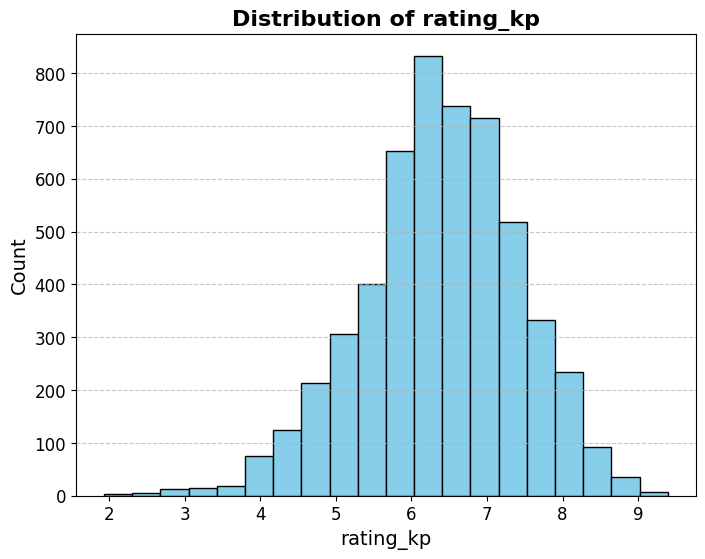

In [1040]:
# Анализ распределения
plot_hist(df_kp, 'rating_kp')

- Отмечается, что большая часть видео-контента имеет рейтинг выше 6.

In [1041]:
# Контент с низким рейтингом
_q5 = df_kp['rating_kp'] < 4
df_kp[_q5].groupby('genre')['id'].count().sort_values(ascending=False)

genre
ужасы              44
фантастика         14
комедия            10
драма               5
боевик              4
фэнтези             4
приключения         3
мелодрама           2
документальный      1
история             1
короткометражка     1
криминал            1
триллер             1
Name: id, dtype: int64

In [1042]:
# Контент с высоким рейтингом
_q6 = df_kp['rating_kp'] > 8
df_kp[_q6].groupby('genre')['id'].count().sort_values(ascending=False)

genre
документальный     145
короткометражка     36
драма               35
комедия             13
музыка              12
концерт             11
мюзикл               7
биография            5
семейный             4
реальное ТВ          4
приключения          4
история              4
фэнтези              3
мелодрама            3
боевик               2
военный              2
спорт                2
ужасы                2
игра                 1
детектив             1
фантастика           1
криминал             1
Name: id, dtype: int64

In [1043]:
_q7 = df_kp['genre'] == 'документальный'

In [1044]:
df_kp[_q6 & _q7].groupby('country')['id'].count().sort_values(ascending=False)

country
Россия            77
США               26
Франция           10
Великобритания     8
Корея Южная        5
Германия           3
Австралия          1
Беларусь           1
Испания            1
Италия             1
Канада             1
Нидерланды         1
Швейцария          1
Name: id, dtype: int64

In [1045]:
# Средний рейтинг по жанрам или странам.
df_kp.groupby('genre')[['rating_kp']].agg('mean').sort_values(by='rating_kp', ascending=False)

,rating_kp
genre,
концерт,7.903455
игра,7.722750
реальное ТВ,7.624250
документальный,7.539013
музыка,7.348722
биография,7.153755
семейный,7.127718
спорт,7.071118
мюзикл,6.911588


- Среди контента с высоким рейтингом (> 8) больше всего документальных фильмов, а с низким (< 4) фильмы ужасов.
- При этом, жанры с самым высоким средним рейтингом: концерт, реальное ТВ, музыка. Однако, здесь играет большую роль количество наблюдений в каждой группе.

In [1046]:
df_kp.groupby('genre')[['id']].agg('count').sort_values(by='id', ascending=False)

,id
genre,
драма,1122
комедия,677
ужасы,557
документальный,529
боевик,472
триллер,460
короткометражка,394
мелодрама,241
фантастика,219


- Группы с самым высоким рейтингом имеют весьма небольшое количество наблюдений.

## 3.6 Рейтинг IMDB

In [1047]:
df['rating_imdb'].describe()

count    74500.000000
mean         1.578903
std          2.858883
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: rating_imdb, dtype: float64

In [1048]:
_df = df[df['rating_imdb'] > 0]

In [1049]:
_df['rating_imdb'].describe()

count    18297.000000
mean         6.428830
std          1.448873
min          1.000000
25%          5.600000
50%          6.500000
75%          7.400000
max         10.000000
Name: rating_imdb, dtype: float64

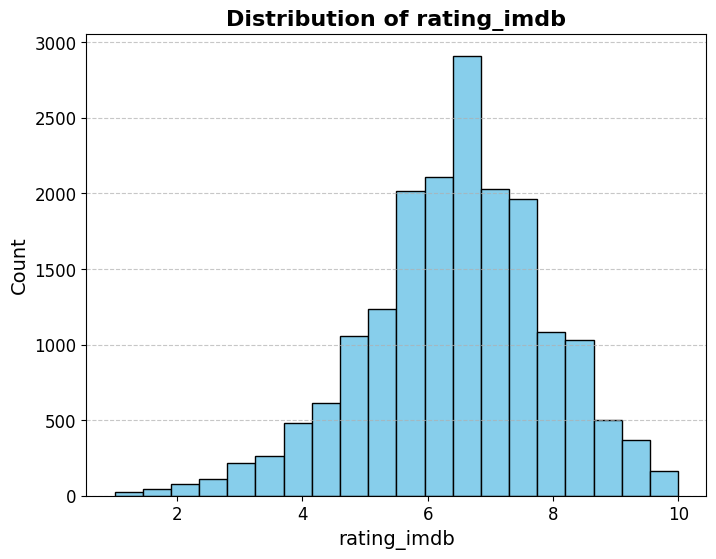

In [1050]:
plot_hist(_df, 'rating_imdb')

# 4. Подготовка данных к статистическим тестам и моделированию

Перед выполнением статистических тестов и МО необходимо подготовить отдельный датасет:
- Не содержащий 0 в рейтингах.
- Не имеющий пропущенных значений.

In [1051]:
# Общее число пропусков
df.isna().mean().sort_values(ascending=False)

age_rating         0.899302
movie_length       0.302430
country            0.047758
genre              0.012376
id                 0.000000
name               0.000000
year               0.000000
tickets_on_sale    0.000000
rating_kp          0.000000
rating_imdb        0.000000
dtype: float64

1. Весьма большое число пропусков в возрастном ограничении, при этом данный признак скорее всего важен.
2. Длину фильма заполним средним по жанру.
3. Строчки со страной можно отбросить, т.к. в этом случае нет логичного способа заполнить пропуски.
4. Строчки с пропусками в жанре также отбросим.

In [1052]:
# Сначала отберём только те строки, где рейтинг не нулевой на обеих платформах
df_cleansed = df[(df['rating_kp'] > 0) & (df['rating_imdb'] > 0)]
df_cleansed.isna().mean().sort_values(ascending=False)

age_rating         0.160804
movie_length       0.007766
country            0.002513
genre              0.000685
id                 0.000000
name               0.000000
year               0.000000
tickets_on_sale    0.000000
rating_kp          0.000000
rating_imdb        0.000000
dtype: float64

In [1053]:
# Пропусков в возрастном ограничении теперь гораздо меньше, заполним средним по жанру
df_cleansed.loc[:, 'age_rating'] = df_cleansed.groupby('genre')['age_rating'].transform(lambda x: x.fillna(x.mean()))
df_cleansed.isna().mean().sort_values(ascending=False)

movie_length       0.007766
country            0.002513
age_rating         0.001827
genre              0.000685
id                 0.000000
name               0.000000
year               0.000000
tickets_on_sale    0.000000
rating_kp          0.000000
rating_imdb        0.000000
dtype: float64

In [1054]:
# Оставшиеся пропуски можно убрать
df_cleansed = df_cleansed.dropna()
df_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4331 entries, 59 to 74274
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4331 non-null   int64  
 1   name             4331 non-null   object 
 2   year             4331 non-null   int64  
 3   movie_length     4331 non-null   float64
 4   age_rating       4331 non-null   float64
 5   tickets_on_sale  4331 non-null   bool   
 6   country          4331 non-null   object 
 7   genre            4331 non-null   object 
 8   rating_kp        4331 non-null   float64
 9   rating_imdb      4331 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 342.6+ KB


In [1055]:
df_cleansed['age_rating'] = df_cleansed['age_rating'].astype(int)
df_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4331 entries, 59 to 74274
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4331 non-null   int64  
 1   name             4331 non-null   object 
 2   year             4331 non-null   int64  
 3   movie_length     4331 non-null   float64
 4   age_rating       4331 non-null   int64  
 5   tickets_on_sale  4331 non-null   bool   
 6   country          4331 non-null   object 
 7   genre            4331 non-null   object 
 8   rating_kp        4331 non-null   float64
 9   rating_imdb      4331 non-null   float64
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 342.6+ KB


In [1056]:
df_cleansed = df_cleansed.drop('id', axis=1)

In [1057]:
continuous = df_cleansed.select_dtypes(include='float64').columns.tolist()
discrete = df_cleansed.select_dtypes(include='int64').columns.tolist()
categoric = df_cleansed.select_dtypes(include='object').columns.tolist()

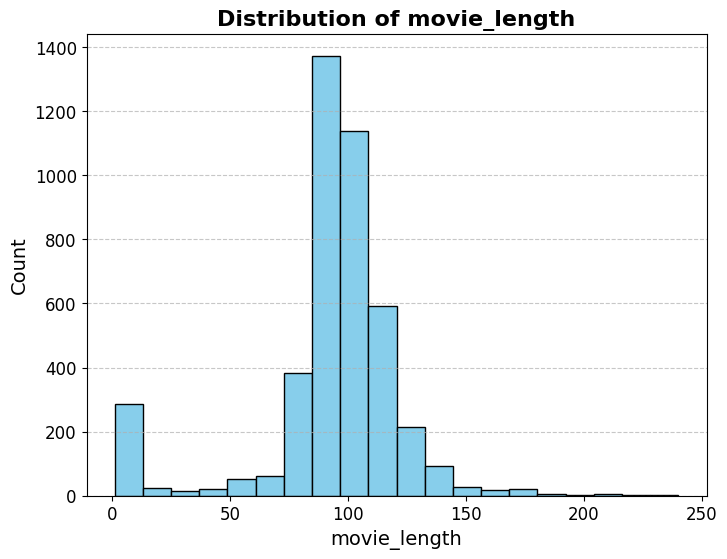

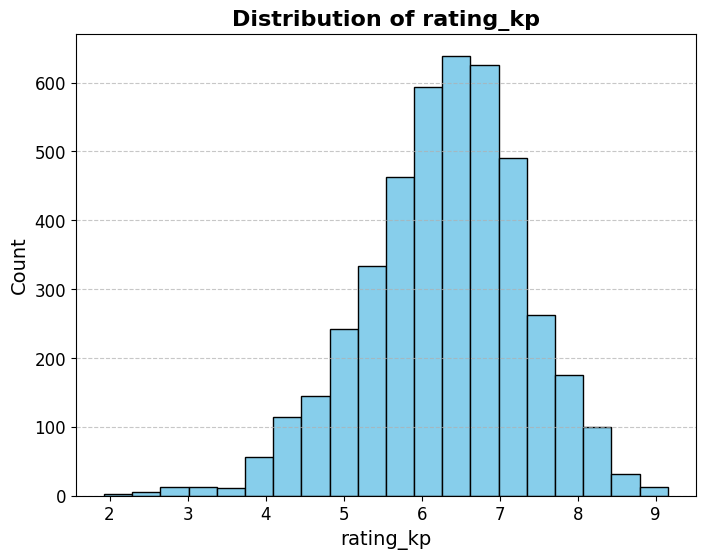

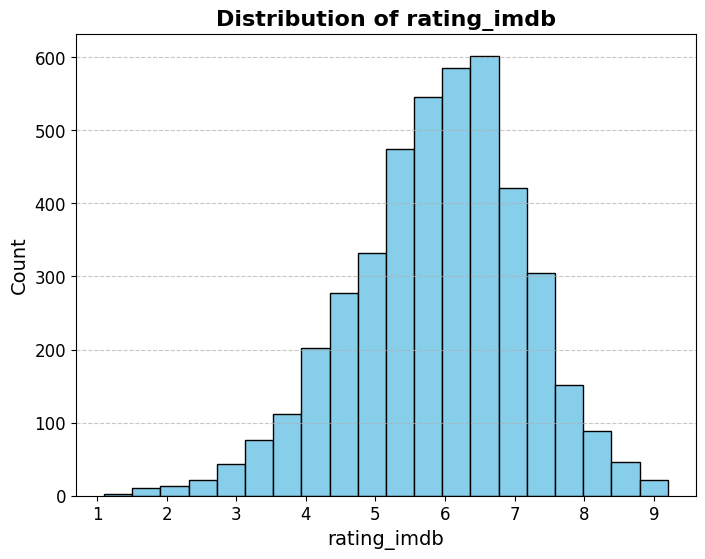

In [1058]:
for col in df_cleansed[continuous]:
    plot_hist(df_cleansed, col)

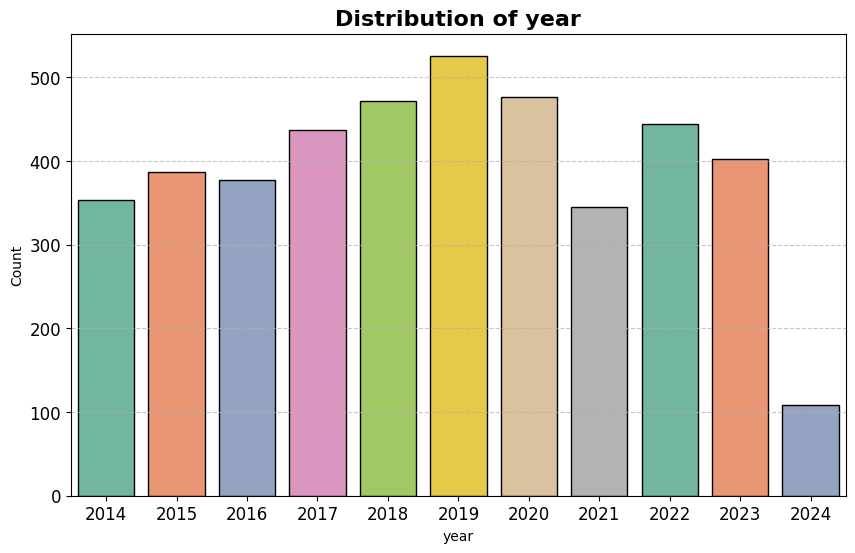

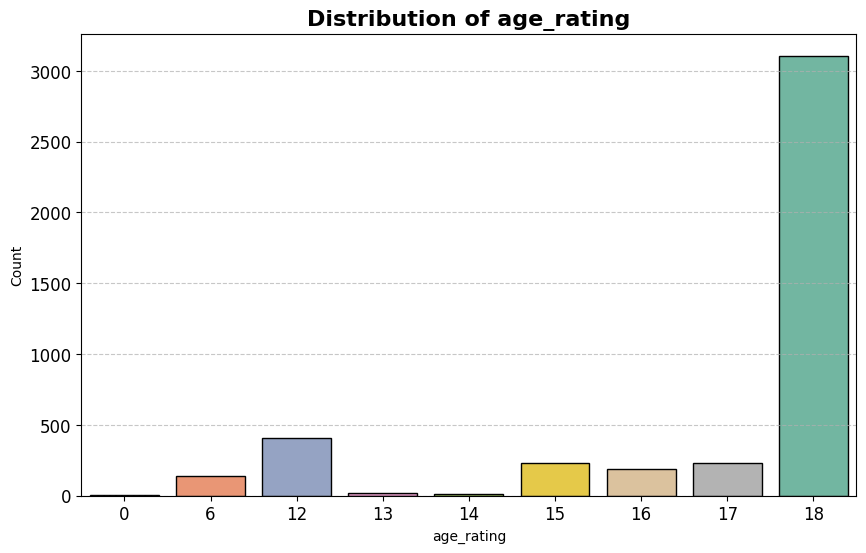

In [1059]:
for col in df[discrete]:
    plot_countplot(df_cleansed, col)

In [1060]:
for col in df_cleansed[categoric]:
    print(col, len(df_cleansed[col].unique()))

name 4276
country 71
genre 25


Таким образом, для проверки гипотез и моделирования имеется датасет, в котором содержится:
- 1 непрерывный количественный признак - длина видеоконтента. Распределение бимодальное, два пика для коротких и длинных фильмов.
- 2 дискретных количественных признака - год, возрастное ограничение. 
- 2 категориальных признака - 71 страна и 25 жанров,
- 2 возможных таргета - рейтинги Кинопоиск, IMDB (непрерывные величины).

# 5. Статистические тесты

## 5.1. Различие в рейтингах между двумя платформами: Кинопоиск и IMDb

Поскольку в датасете присутствуют рейтинги из **двух** источников, в начале необходимо выяснить, есть ли в них различия.

- Нулевая гипотеза (H0): Средние рейтинги фильмов на Кинопоиск и IMDb одинаковы.
- Альтернативная гипотеза (H1): Средние рейтинги фильмов на Кинопоиск и IMDb отличаются.

**Визуальная оценка распределений плотности вероятностей**

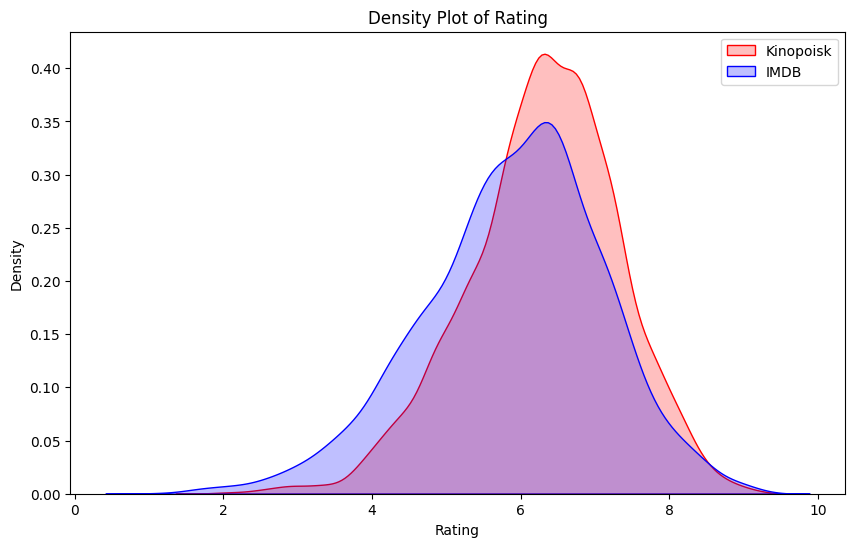

In [1061]:
# KDE плоты для распределений рейтингов
plt.figure(figsize=(10, 6))

sns.kdeplot(df_cleansed['rating_kp'], fill=True, color="r", label="Kinopoisk")
sns.kdeplot(df_cleansed['rating_imdb'], fill=True, color="b", label="IMDB")

plt.title("Density Plot of Rating")
plt.xlabel("Rating")
plt.ylabel("Density")

plt.legend()
plt.show()

- У Кинопоиска большинство оценок сосредоточено в диапазоне 5 - 8, с пиком плотности в районе оценки 6.5.
- У IMDB пик также находится в районе 6.5.
- При этом оценки у IMDB имеют более широкий разброс и меньшие значения плотности на концах распределения.
- Плотность вероятности на высоких оценках выше у Кинопоиска, что говорит о том, что на Кинопоиске большее число фильмов получили высокие оценки.
- Вероятно, есть различия в аудиториях или в оценочных критериях на этих платформах.

**Проверка гипотезы с помощью статистического теста**

In [1062]:
# Уровень стат.значимости
alpha = 0.05

# Две группы оценок
ratings_kp = df_cleansed['rating_kp']
ratings_imdb = df_cleansed['rating_imdb']

# Выполнение двухвыборочного t-теста
t_statistic, p_value = st.ttest_ind(ratings_kp, ratings_imdb, equal_var=False)

print(f't-статистика: {t_statistic}')
print(f'p-значение: {p_value}')

# Интерпретация результата
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Между рейтингами на Kinopoisk и IMDb существует статистически значимая разница.")
else:
    print("Статистически значимой разницы между рейтингами на Kinopoisk и IMDb нет.")

t-статистика: 16.570700172367854
p-значение: 1.0394773268399405e-60
Отвергаем нулевую гипотезу в пользу альтернативной. Между рейтингами на Kinopoisk и IMDb существует статистически значимая разница.


Различия в рейтингах на Кинопоиске и IMDB статистически значимы, следовательно, присутствует два таргета, и предсказания будем делать по обеим платформам.

## 4.2 Влияние жанра на средний рейтинг фильма
- Нулевая гипотеза (H0): Средние рейтинги фильмов одинаковы для всех жанров.
- Альтернативная гипотеза (H1): Средние рейтинги фильмов различаются в зависимости от жанра.

### 4.2.1 Рейтинг Кинопоиск

In [1063]:
from scipy.stats import f_oneway

# Разделение данных по жанрам
genre_groups = [df_cleansed[df_cleansed['genre'] == genre]['rating_kp'] for genre in df_cleansed['genre'].unique()]

# Проведение однофакторного ANOVA
f_statistic, p_value = f_oneway(*genre_groups)

print(f"F-статистика: {f_statistic}")
print(f"P-значение: {p_value}")

if p_value < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной - есть существенные различия в среднем рейтинге по жанрам')
else:
    print("Нет существенных различий в среднем рейтинге по жанрам")

F-статистика: 103.70251668281912
P-значение: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной - есть существенные различия в среднем рейтинге по жанрам


### 4.2.2 Рейтинг IMDB

In [1064]:
# Разделение данных по жанрам
genre_groups = [df_cleansed[df_cleansed['genre'] == genre]['rating_imdb'] for genre in df_cleansed['genre'].unique()]

# Проведение однофакторного ANOVA
f_statistic, p_value = f_oneway(*genre_groups)

print(f"F-статистика: {f_statistic}")
print(f"P-значение: {p_value}")

if p_value < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной - есть существенные различия в среднем рейтинге по жанрам')
else:
    print("Нет существенных различий в среднем рейтинге по жанрам")

F-статистика: 86.41787224083947
P-значение: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной - есть существенные различия в среднем рейтинге по жанрам


## 4.3 Связь между возрастным рейтингом и рейтингом на Кинопоиск или IMDb
- Нулевая гипотеза (H0): Нет корреляции между возрастным рейтингом и рейтингом на Кинопоиск или IMDb.
- Альтернативная гипотеза (H1): Есть значимая корреляция между возрастным рейтингом и рейтингом на Кинопоиск или IMDb.

In [1065]:
# Корреляция между возрастным рейтингом и рейтингом на Кинопоиск
corr_kp, p_value_kp = spearmanr(df_cleansed['age_rating'], df_cleansed['rating_kp'])

# Корреляция между возрастным рейтингом и рейтингом на IMDb
corr_imdb, p_value_imdb = spearmanr(df_cleansed['age_rating'], df_cleansed['rating_imdb'])

print(f"Корреляция (Кинопоиск): {corr_kp}, P-значение: {p_value_kp}")
print(f"Корреляция (IMDb): {corr_imdb}, P-значение: {p_value_imdb}")

Корреляция (Кинопоиск): -0.27920583591272674, P-значение: 2.1961389457157762e-78
Корреляция (IMDb): -0.19334167131959026, P-значение: 9.593155185729068e-38


На основе представленных результатов корреляционного анализа:

Корреляция между возрастным рейтингом и рейтингом на Кинопоиск:

Коэффициент корреляции: -0.289
P-значение: 1.12e-35 (очень маленькое значение)
Корреляция между возрастным рейтингом и рейтингом на IMDb:

Коэффициент корреляции: -0.180
P-значение: 1.70e-14 (тоже очень маленькое значение)
Интерпретация результатов:
P-значения для обеих корреляций очень малы (намного меньше стандартного уровня значимости 0.05), что означает, что нулевую гипотезу о том, что нет корреляции между возрастным рейтингом и рейтингами на Кинопоиск и IMDb, можно отвергнуть. Это свидетельствует о том, что существует статистически значимая корреляция между возрастным рейтингом и рейтингами на обоих сайтах.

Коэффициенты корреляции для Кинопоиск и IMDb отрицательные, что говорит о том, что с увеличением возрастного рейтинга рейтинг фильмов имеет тенденцию уменьшаться. Однако, корреляции -0.289 и -0.180 указывают на слабую отрицательную корреляцию:

Для Кинопоиск (-0.289) корреляция чуть более выражена, чем для IMDb (-0.180).
Тем не менее, обе корреляции все еще находятся в пределах слабой корреляции (от 0 до 0.3).
Вывод:
Несмотря на статистически значимую корреляцию, ее сила невелика, что означает, что возрастной рейтинг оказывает лишь незначительное влияние на рейтинг фильмов на обоих сайтах.

4.4 Наличие продажи билетов как фактор популярности фильма
- Нулевая гипотеза (H0): Наличие продажи билетов не влияет на рейтинг фильма.
- Альтернативная гипотеза (H1): Фильмы, на которые продаются билеты, имеют различный рейтинг по сравнению с теми, на которые билеты не продаются.

In [1066]:
# Две группы оценок
tickets_true = df_cleansed[df_cleansed['tickets_on_sale'] == True]['rating_kp']
tickets_false = df_cleansed[df_cleansed['tickets_on_sale'] == True]['rating_kp']

# Выполнение двухвыборочного t-теста
t_statistic, p_value = st.ttest_ind(tickets_true, tickets_false, equal_var=False)

print(f't-статистика: {t_statistic}')
print(f'p-значение: {p_value}')

# Интерпретация результата
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Фильмы, на которые продаются билеты, имеют различный рейтинг по сравнению с теми, на которые билеты не продаются.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Наличие продажи билетов не влияет на рейтинг фильма.")

t-статистика: 0.0
p-значение: 1.0
Не можем отвергнуть нулевую гипотезу. Наличие продажи билетов не влияет на рейтинг фильма.


4. Влияние длительности фильма на его рейтинг
Нулевая гипотеза (H0): Длительность фильма не влияет на его рейтинг.
Альтернативная гипотеза (H1): Длительность фильма влияет на его рейтинг.
5. Отличие в средних рейтингах фильмов в зависимости от страны производства
Нулевая гипотеза (H0): Средние рейтинги фильмов не зависят от страны производства.
Альтернативная гипотеза (H1): Средние рейтинги фильмов зависят от страны производства.
6. Наличие продажи билетов как фактор популярности фильма
Нулевая гипотеза (H0): Наличие продажи билетов не влияет на рейтинг фильма.
Альтернативная гипотеза (H1): Фильмы, на которые продаются билеты, имеют различный рейтинг по сравнению с теми, на которые билеты не продаются.
Для тестирования этих гипотез можно использовать различные статистические методы, такие как t-тесты, ANOVA, корреляционный анализ и другие, в зависимости от типа данных и гипотезы.

In [1067]:
from phik import phik_matrix

In [1068]:
matrix = df_cleansed.phik_matrix()

interval columns not set, guessing: ['year', 'movie_length', 'age_rating', 'rating_kp', 'rating_imdb']


/opt/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 4276. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


In [1069]:
matrix

,name,year,movie_length,age_rating,tickets_on_sale,country,genre,rating_kp,rating_imdb
name,1.000000,0.000000,0.930333,0.975189,1.000000,0.922738,0.984717,0.873674,0.888789
year,0.000000,1.000000,0.188291,0.177717,0.165938,0.175004,0.204302,0.127050,0.185154
movie_length,0.930333,0.188291,1.000000,0.518919,0.094550,0.396008,0.760900,0.412461,0.511284
age_rating,0.975189,0.177717,0.518919,1.000000,0.000000,0.307672,0.787428,0.298441,0.307661
tickets_on_sale,1.000000,0.165938,0.094550,0.000000,1.000000,0.148815,0.000000,0.064398,0.098538
country,0.922738,0.175004,0.396008,0.307672,0.148815,1.000000,0.422163,0.259643,0.284966
genre,0.984717,0.204302,0.760900,0.787428,0.000000,0.422163,1.000000,0.577305,0.558936
rating_kp,0.873674,0.127050,0.412461,0.298441,0.064398,0.259643,0.577305,1.000000,0.824608
rating_imdb,0.888789,0.185154,0.511284,0.307661,0.098538,0.284966,0.558936,0.824608,1.000000


In [1070]:
len(df_cleansed['name'].unique())

4276

In [1071]:
df_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4331 entries, 59 to 74274
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             4331 non-null   object 
 1   year             4331 non-null   int64  
 2   movie_length     4331 non-null   float64
 3   age_rating       4331 non-null   int64  
 4   tickets_on_sale  4331 non-null   bool   
 5   country          4331 non-null   object 
 6   genre            4331 non-null   object 
 7   rating_kp        4331 non-null   float64
 8   rating_imdb      4331 non-null   float64
dtypes: bool(1), float64(3), int64(2), object(3)
memory usage: 308.8+ KB


# 6. Модель МО

- **Задача:** предсказание рейтинга фильма на платформах Кинопоиск и IMDB на основе характеристик фильма, что является задачей регрессии, т.к. признаки 'rating_kp' и 'rating_imdb' в данном датасете являются непрерывными.
- **Метрика:** В качестве метрики выбираем RMSE, т.к. данная метрика показывает, на сколько в среднем ошибается модель, и такую метрику легко интерпретировать.

In [1072]:
df_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4331 entries, 59 to 74274
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             4331 non-null   object 
 1   year             4331 non-null   int64  
 2   movie_length     4331 non-null   float64
 3   age_rating       4331 non-null   int64  
 4   tickets_on_sale  4331 non-null   bool   
 5   country          4331 non-null   object 
 6   genre            4331 non-null   object 
 7   rating_kp        4331 non-null   float64
 8   rating_imdb      4331 non-null   float64
dtypes: bool(1), float64(3), int64(2), object(3)
memory usage: 308.8+ KB


In [1073]:
# Отделение таргета
X = df_cleansed[['year', 'movie_length', 'age_rating', 'country', 'genre']]
y = df_cleansed['rating_kp']

# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((3248, 5), (1083, 5))

In [1074]:
# Разделение признаков на категориальные и числовые
cat_features = ['country', 'genre']
num_features = ['year', 'movie_length', 'age_rating']

# Предобработка признаков
preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

Шаг 1. Baseline

In [1075]:
# # В качестве Baseline используем линейную регрессию
# model = LinearRegression()

# # Расчёт метрики на кросс-валидации
# result = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [1076]:
# # Значения метрики в каждом
# - result

In [1077]:
# # Среднее RMSE
# rmse_00 = -result.mean()
# rmse_00

Шаг 2. Перебор гиперпараметров и других регрессионных моделей

In [1078]:
# Пайплайн включаюший baseline и пердобработку
rating_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]
)

# Список моделей и параметров для перебора
param_distributions = [
    {
        'regressor': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'regressor': [DecisionTreeRegressor(random_state=42)],
        'regressor__max_depth': [5, 10, None],
        'regressor__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [1079]:
# Поиск оптимальной модели с помощью случайного поиска

search = RandomizedSearchCV(
    estimator=rating_pipe,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
)

In [1080]:
# Обучение
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['country',
                                                                                'genre']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['year',
                                                                                'movie_length',
                                                                                'age_rating'])])),
                                             ('regressor',
                                              LinearRegression())]),
                   param_distributions=[{'preprocessor__num': [StandardScaler(),
                                                               MinMa...
                                         'regressor__max_depth': [5, 10, None],
                                         'regressor__min_samples_split': [2, 5,
                                                                          10]},
                                        {'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'regressor': [RandomForestRegressor(random_state=42)],
                                         'regressor__max_depth': [10, 20, None],
                                         'regressor__min_samples_split': [2, 5,
                                                                          10],
                                         'regressor__n_estimators': [100,
                                                                     200]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [1081]:
# Метрика на кросс-валидации
search.best_score_

-0.750011456614968

In [1082]:
# Метрика на тестовых данных
y_pred = search.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred)
rmse_test

0.7222099757296578

- Модель немного недоучивается. Попробуем feature engineering.
- Вероятно попробуем выделить новый признак из названия.

In [1083]:
# Отделение таргета
X = df_cleansed[['name', 'year', 'movie_length', 'age_rating', 'country', 'genre']].copy()
y = df_cleansed['rating_kp']

X['name_length'] = X['name'].apply(len)
X['name_word_count'] = X['name'].apply(lambda x: len(x.split()))

# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((3248, 8), (1083, 8))

In [1084]:
# Разделение признаков на категориальные и числовые
cat_features = ['country', 'genre']
num_features = ['year', 'movie_length', 'age_rating', 'name_length', 'name_word_count']

# Предобработка признаков
preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

# Пайплайн включаюший baseline и пердобработку
rating_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]
)

# Список моделей и параметров для перебора
param_distributions = [
    {
        'regressor': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'regressor': [DecisionTreeRegressor(random_state=42)],
        'regressor__max_depth': [5, 10, None],
        'regressor__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [1085]:
# Поиск оптимальной модели с помощью случайного поиска

search_2 = RandomizedSearchCV(
    estimator=rating_pipe,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
)

In [1086]:
search_2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['country',
                                                                                'genre']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['year',
                                                                                'movie_length',
                                                                                'age_rating',
                                                                                'name_length',
                                                                                'name_word_count'])])),
                                             ('regressor',
                                              LinearRegression())]),
                   param_distributions=[{'preprocess...
                                         'regressor__max_depth': [5, 10, None],
                                         'regressor__min_samples_split': [2, 5,
                                                                          10]},
                                        {'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'regressor': [RandomForestRegressor(random_state=42)],
                                         'regressor__max_depth': [10, 20, None],
                                         'regressor__min_samples_split': [2, 5,
                                                                          10],
                                         'regressor__n_estimators': [100,
                                                                     200]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [1087]:
search_2.best_score_

-0.7513140377214924

In [ ]:
# Метрика на тестовых данных
y_pred_2 = search_2.predict(X_test)
rmse_test_2 = root_mean_squared_error(y_test, y_pred)
rmse_test_2

0.7184611977144988

- Метрика на кросс-валидации увеличилась, а на тестовой выборке уменьшилась, что показывает, что новые признаки не помогают модели. 
- Оставляем первоначальную модель.

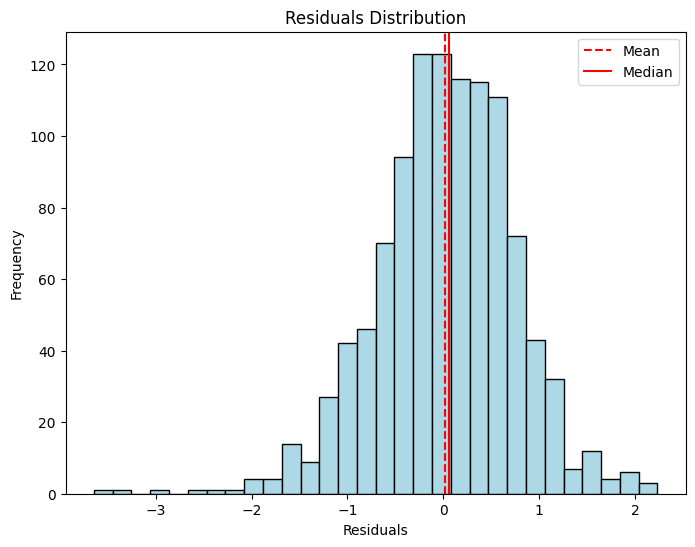

In [971]:
# Рассчёт остатков
residuals = y_test - y_pred

# График остатков
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='lightblue', edgecolor='black')
plt.axvline(x=residuals.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(x=residuals.median(), color='red', linestyle='-', label='Median')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

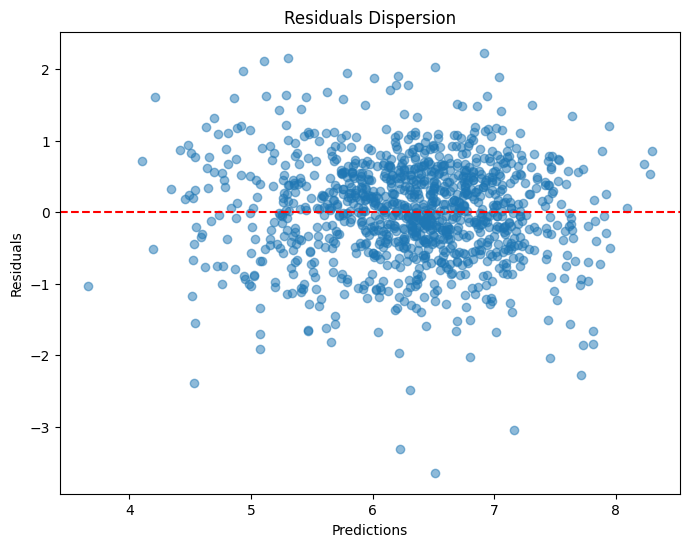

In [972]:
# Оценка дисперсии остатков

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Dispersion')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

1. Значение метрики R2 для Модели №3 составляет примерно 0.831, что выше, чем у Моделей №1,2. Это означает, что в 83 % случаев предсказание модели точнее, чем среднее значение целевого признака.

2. Остатки имеют нормальное распределение с выбросами, смещение относительно нуля минимальное.

3. Дисперсия Модели №3 не идеальная, но наиболее однородная.

In [ ]:
# Проверка модели на адекватность
quit_pipe_dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

quit_pipe_dummy.fit(X_train, y_train)
y_pred_dummy = quit_pipe_dummy.predict(X_test)

rmse_test_dummy = root_mean_squared_error(y_test, y_pred_dummy)
rmse_test_dummy

1.0066951644517566

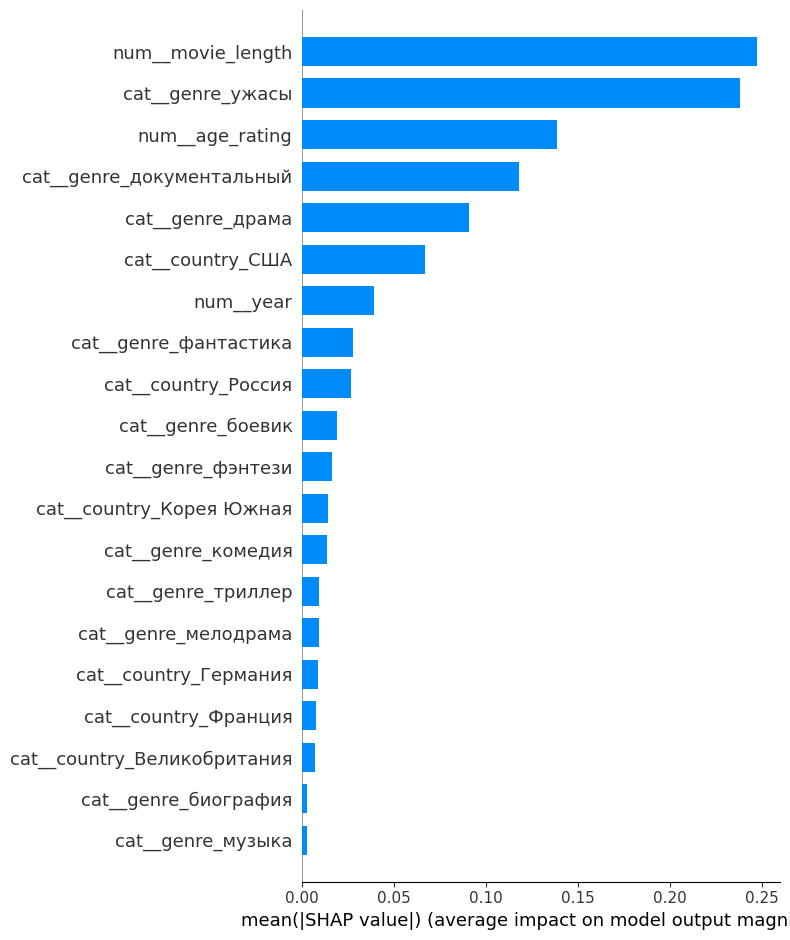

In [ ]:
import shap

# Extract the final model (RandomForestRegressor) from the pipeline
model = search.best_estimator_.named_steps['regressor']

# Get feature names after preprocessing
feature_names = search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Transform the training data
x_Train_transformed = search.best_estimator_.named_steps['preprocessor'].transform(X_train)

# Create TreeExplainer for the model (only the model is passed)
explainer = shap.TreeExplainer(model)

# Compute SHAP values (use the transformed data)
shap_values = explainer.shap_values(x_Train_transformed)

# Visualize SHAP values with a bar plot
shap.summary_plot(shap_values, features=x_Train_transformed, feature_names=feature_names, plot_type="bar")

# Show the plot
plt.show()

RMSE DummyRegressor: 1.01
DummyRegressor предсказывает базовое значение, не учитывая входные признаки. Высокое значение RMSE (1.01) говорит о том, что такие базовые предсказания сильно отклоняются от реальных значений целевой переменной.

RMSE RandomForestRegressor: 0.72
Значительно более низкое значение RMSE (0.72) для RandomForestRegressor указывает на то, что эта модель лучше прогнозирует значения целевой переменной, используя информацию из признаков. Она существенно уменьшает ошибку по сравнению с базовой моделью.

Вывод: Модель RandomForestRegressor явно лучше базовой модели (DummyRegressor). Это указывает на то, что случайный лес эффективно извлекает информацию из признаков и делает более точные прогнозы. Разница между RMSE двух моделей также подтверждает, что RandomForestRegressor лучше учитывает структуру данных, тогда как базовая модель не может этого сделать.

2. Классификация (Classification)
Задача: Определение, будет ли фильм иметь высокий или низкий рейтинг (например, выше или ниже определённого порога).
Модель: Логистическая регрессия, дерево решений, случайный лес, градиентный бустинг.

Целевая переменная: Бинарный класс, основанный на рейтинге (например, rating_kp > 7 или rating_imdb > 7)
Признаки (features): year, movie_length, age_rating, tickets_on_sale, country, genre

3. Кластеризация (Clustering)
Задача: Группировка фильмов на основе их характеристик (например, для создания рекомендаций или анализа похожих фильмов).
Модель: K-средних (K-Means), агломеративная кластеризация.

Признаки (features): year, movie_length, age_rating, country, genre

4. Анализ взаимосвязей (Association Analysis)
Задача: Поиск ассоциаций между различными характеристиками фильмов (например, связь между жанром и возрастным рейтингом).
Модель: Apriori, FP-Growth (часто используется для анализа корзин покупок).

Данные: genre, age_rating, country


Для ответа на вопрос о том, достаточно ли данных в вашем предоставленном датасете, нужно учитывать несколько факторов, связанных с целями вашего анализа или построения модели.

1. Задача анализа или моделирования:
Тип задачи: Если ваша цель — провести базовый анализ данных или построить простую модель предсказания, то 1784 записи могут быть достаточно, особенно если данные хорошо сбалансированы и не содержат значительных пропусков.
Сложность задачи: Для сложных моделей (например, нейронных сетей) или более точного предсказания (например, с высокой точностью) может потребоваться больше данных для обучения и тестирования модели.
2. Качество данных:
Полнота данных: Важным фактором является отсутствие пропусков в данных. В вашем датасете все колонки содержат данные для всех 1784 записей, что является положительным аспектом.
Разнообразие данных: Важно убедиться, что данные охватывают разнообразие возможных ситуаций, например, разные жанры, страны, годы и возрастные рейтинги.
3. Представленность классов и распределение данных:
Баланс классов: Если в данных имеется сильный перекос в распределении целевого признака (например, один жанр сильно преобладает), это может негативно сказаться на качестве моделей классификации.
Распределение признаков: Стоит оценить распределение всех признаков, чтобы понять, насколько они репрезентативны и позволяют ли сделать обоснованные выводы.
4. Целевое применение:
Практическое применение: Для задач, где важны точность и надежность предсказаний (например, прогнозирование успеха фильма), может потребоваться больше данных для повышения стабильности модели.
Экспериментальная задача: Если ваш анализ носит исследовательский характер и не требует высокой точности, текущий объем данных может быть достаточным для получения предварительных выводов.
Итог:
1784 записи могут быть достаточными для базового анализа и построения простых моделей, однако для более сложных задач или для повышения точности предсказаний может потребоваться больше данных. Также важно учитывать баланс и репрезентативность данных в контексте конкретной задачи.

Статистические тесты и модели машинного обучения, описанные ранее, могут предоставить значительные бизнес-ценности в различных аспектах анализа данных и принятия решений в сфере киноиндустрии или любой другой отрасли, связанной с развлекательным контентом. Вот несколько примеров:

1. Регрессионные модели
Прогнозирование рейтингов:

Бизнес-ценность: Помогает продюсерам и студиям прогнозировать успех фильма на основе его характеристик, таких как продолжительность, год выпуска, возрастной рейтинг и жанр. Это может позволить принимать более обоснованные решения о финансировании проектов, маркетинговых стратегиях и целевых аудиториях.
Использование: На ранних этапах производства можно оценивать потенциальные рейтинги и при необходимости вносить коррективы в проект.
2. Классификационные модели
Определение популярных фильмов:

Бизнес-ценность: Определение вероятности того, что фильм получит высокий рейтинг, помогает кинотеатрам и стриминговым платформам более эффективно выбирать контент для показа. Это увеличивает шансы на привлечение аудитории и повышение доходов.
Использование: Можно использовать для создания списков фильмов, которые с большей вероятностью станут хитами.
3. Кластеризация
Группировка фильмов для маркетинга и рекомендаций:

Бизнес-ценность: Кластеризация фильмов на основе их характеристик позволяет более эффективно сегментировать рынок и предлагать целевые маркетинговые кампании. Также можно улучшить рекомендательные системы, предлагая пользователям похожие фильмы на основе их предпочтений.
Использование: Рекламные кампании могут быть более персонализированы для различных сегментов аудитории, что приведет к лучшему отклику и увеличению продаж билетов или подписок.
4. Анализ взаимосвязей
Поиск ассоциаций между характеристиками фильмов:

Бизнес-ценность: Анализ взаимосвязей между жанром, возрастным рейтингом и успехом на платформе помогает оптимизировать библиотеку контента. Понимание того, какие сочетания характеристик приводят к успеху, может использоваться для принятия решений о покупке прав на фильмы или разработки контента.
Использование: Платформы могут лучше управлять своим каталогом, выделяя ресурсы на наиболее востребованные типы контента.
5. Рекомендательные системы
Предложение персонализированного контента:

Бизнес-ценность: Рекомендательные системы значительно повышают удержание пользователей на платформах, таких как стриминговые сервисы, за счет предложений релевантного контента, который пользователи с большей вероятностью посмотрят. Это ведет к увеличению времени использования платформы и снижению оттока клиентов.
Использование: Повышение лояльности клиентов и увеличение прибыли за счет персонализированных рекомендаций.
6. Статистические тесты
Проверка гипотез:

Бизнес-ценность: Статистические тесты, такие как t-тест или u-тест, помогают принимать обоснованные решения на основе данных. Например, можно протестировать, действительно ли новый жанр фильма имеет больше шансов на успех, или убедиться в значимой корреляции между характеристиками фильма и его рейтингом.
Использование: Использование результатов тестов для более точного прогнозирования успеха фильмов, улучшения маркетинговых стратегий и управления портфелем фильмов.
Эти статистические тесты и модели позволяют компаниям действовать на основе данных, что повышает эффективность бизнес-процессов, снижает риски и увеличивает прибыль.

In [ ]:
rating_0 = df[df['rating_kp']== 0].copy()

In [ ]:
rating_0.head()

,id,name,year,movie_length,age_rating,tickets_on_sale,country,genre,rating_kp,rating_imdb
0,1000048,Мама.com,2016,123.0,18.0,False,Индия,драма,0.0,5.4
1,5166411,Travis Scott: Butterfly Effect,2017,4.0,NaN,False,США,музыка,0.0,0.0
2,4930664,Arch Enemy: The Race,2017,3.0,NaN,False,Швеция,музыка,0.0,0.0
3,4931329,Arch Enemy: War Eternal,2014,4.0,NaN,False,Швеция,музыка,0.0,0.0
4,4931313,Arch Enemy: The World Is Yours,2017,5.0,NaN,False,Швеция,музыка,0.0,0.0


In [ ]:
rating_0['rating_kp_pred'] = search.predict(rating_0[['year', 'movie_length', 'age_rating', 'tickets_on_sale', 'country', 'genre']])

In [ ]:
rating_0.head()

,id,name,year,movie_length,age_rating,tickets_on_sale,country,genre,rating_kp,rating_imdb,rating_kp_pred
0,1000048,Мама.com,2016,123.0,18.0,False,Индия,драма,0.0,5.4,6.839979
1,5166411,Travis Scott: Butterfly Effect,2017,4.0,NaN,False,США,музыка,0.0,0.0,7.161886
2,4930664,Arch Enemy: The Race,2017,3.0,NaN,False,Швеция,музыка,0.0,0.0,7.196067
3,4931329,Arch Enemy: War Eternal,2014,4.0,NaN,False,Швеция,музыка,0.0,0.0,7.203615
4,4931313,Arch Enemy: The World Is Yours,2017,5.0,NaN,False,Швеция,музыка,0.0,0.0,7.196067
